Кількість дублікатів: 0
Пропущені значення:
id                                 0
is_tv_subscriber                   0
is_movie_package_subscriber        0
subscription_age                   0
bill_avg                           0
reamining_contract             21572
service_failure_count              0
download_avg                     381
upload_avg                       381
download_over_limit                0
churn                              0
dtype: int64


<ipython-input-13-17eaa0510676>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)  # Заповнюємо медіаною


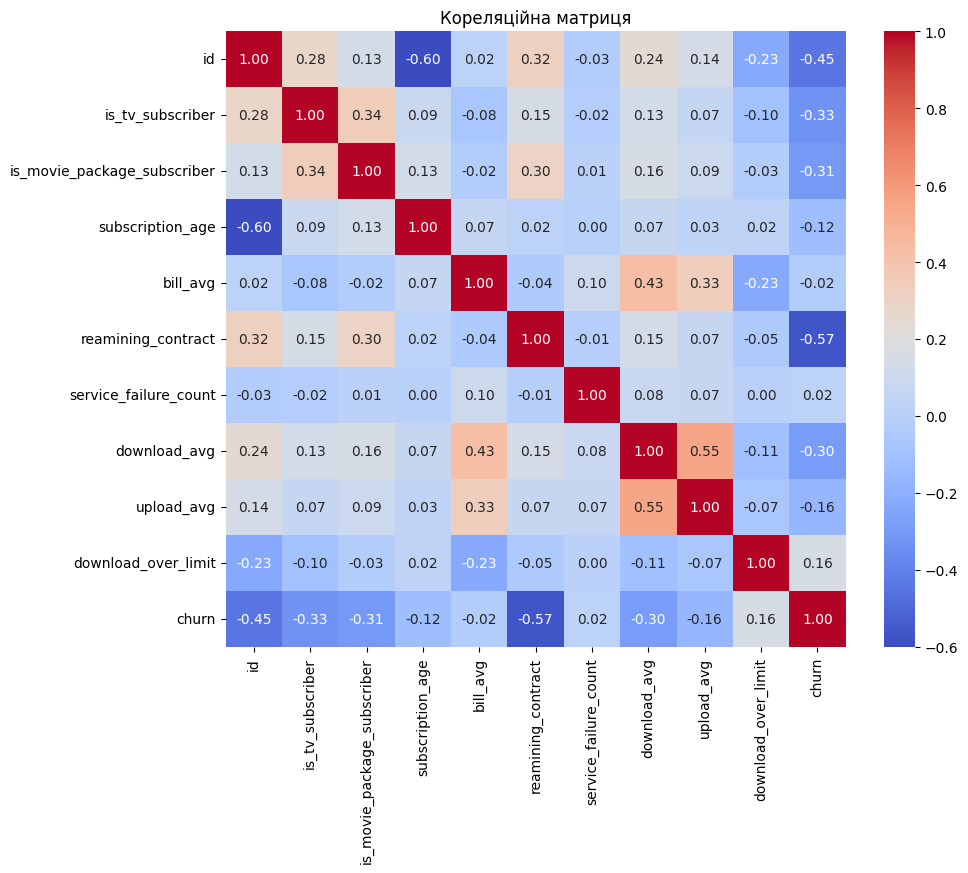

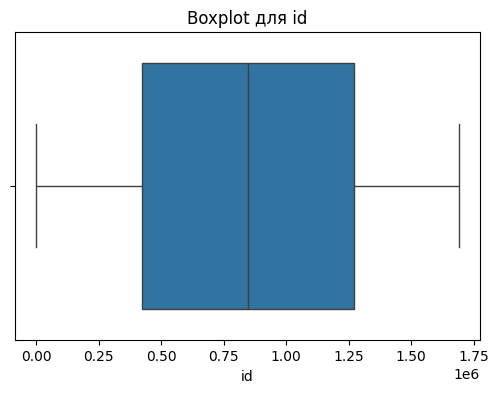

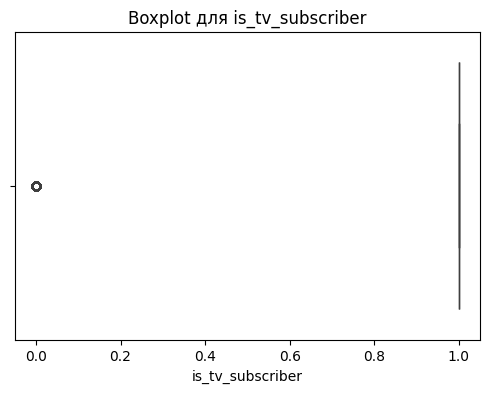

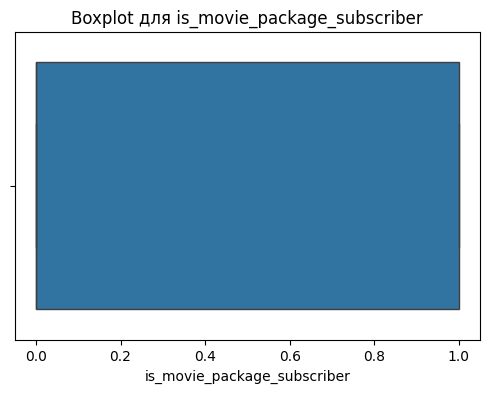

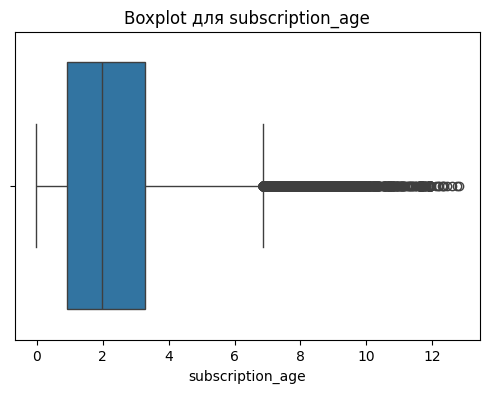

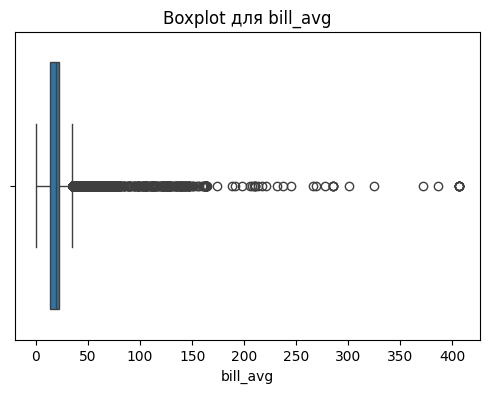

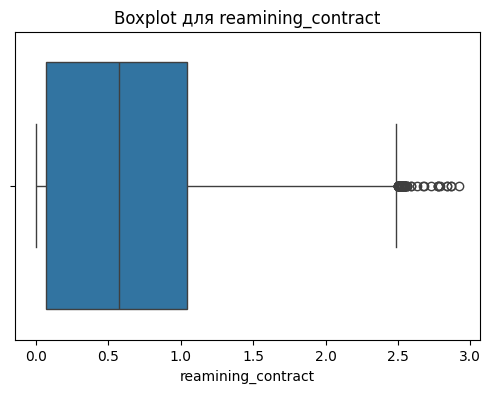

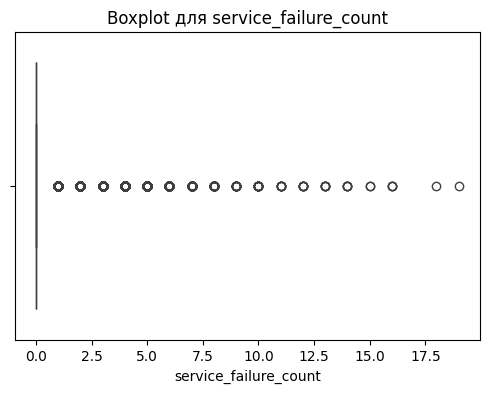

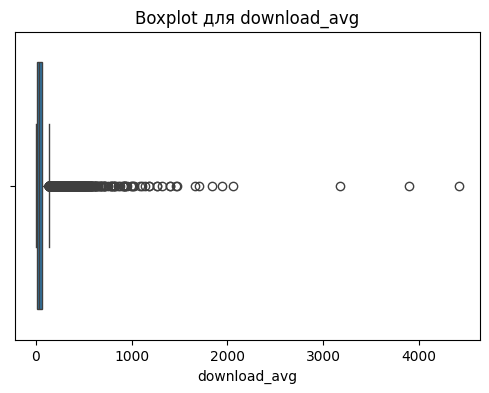

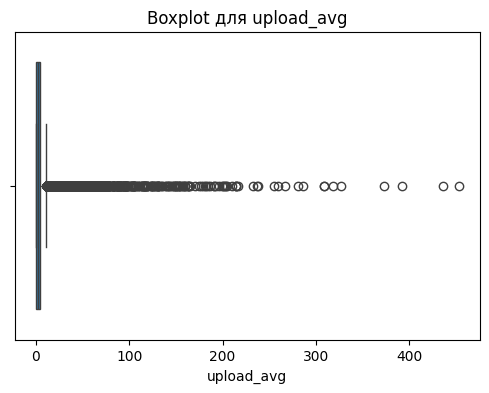

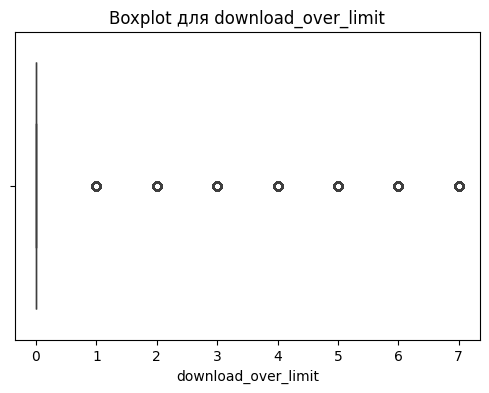

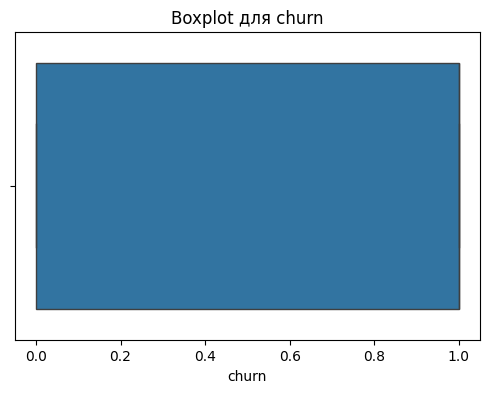

Найкращі параметри: {'model__border_count': 64, 'model__depth': 7, 'model__iterations': 200, 'model__l2_leaf_reg': 1, 'model__learning_rate': 0.1}
Accuracy: 0.9400207540643376
Recall: 0.9392558845861807
Precision: 0.9504417979254706
F1-score: 0.9448157341989689


In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.pipeline import Pipeline

# Завантаження даних
data = pd.read_csv("internet_service_churn.csv")

# 1. Перевірка на дублікати
print("Кількість дублікатів:", data.duplicated().sum())
data = data.drop_duplicates()  # Видалення дублікатів

# 2. Перевірка на пропущені значення
print("Пропущені значення:")
print(data.isnull().sum())

# Заповнення пропущених значень
numerical_cols = data.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].median(), inplace=True)  # Заповнюємо медіаною

categorical_cols = data.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].mode()[0], inplace=True)  # Заповнюємо модою

# 3. Аналіз кореляції
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Кореляційна матриця")
plt.show()

# 4. Виявлення викидів
numerical_cols = data.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot для {col}")
    plt.show()

# Виправлення викидів (обмеження значень)
for col in numerical_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
    data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])

# 5. Підготовка даних для моделі
data = data.drop(columns=["id"])  # Видалення непотрібного стовпця
data = pd.get_dummies(data, drop_first=True)  # Кодування категоріальних змінних

# Розділення на X та y
X = data.drop(columns=["churn"])
y = data["churn"]

# Розділення на тренувальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Побудова моделі з використанням CatBoost
pipeline = Pipeline([
    ("scaler", StandardScaler()),  # Нормалізація даних
    ("model", CatBoostClassifier(random_state=42, verbose=False))  # Модель CatBoost
])

# 7. Навчання моделі з крос-валідацією
param_grid = {
    "model__iterations": [100, 200],  # Кількість ітерацій
    "model__depth": [3, 5, 7],  # Глибина дерева
    "model__learning_rate": [0.01, 0.1],  # Швидкість навчання
    "model__l2_leaf_reg": [1, 3, 5],  # Регуляризація
    "model__border_count": [32, 64]  # Кількість розбиттів
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring="f1", n_jobs=-1)
grid_search.fit(X_train, y_train)

# 8. Найкращі параметри
print("Найкращі параметри:", grid_search.best_params_)

# 9. Оцінка моделі на тестовому наборі
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))